# ECON 3385 - Problem Set 6

Anton Melnychuk

### Question 1

In [ ]:
import pandas as pd
from itertools import combinations

data = pd.read_csv('airlines_long_2.csv')

# Distribution of firms per market
n_firms = data.groupby(['route_id', 'quarter'])['airline_id'].nunique()
dist_table = n_firms.value_counts().sort_index().reset_index()
dist_table.columns = ['Number of Firms', 'Number of Markets']
print("Distribution of Number of Firms per Market:")
print(dist_table)

pairs = []
for (r, q), group in data.groupby(['route_id', 'quarter']):
    airlines = sorted(group['airline_id'].unique())
    pairs.extend(combinations(airlines, 2))

pair_counts = pd.Series(pairs).value_counts()
print("\nTop Pairs of Airlines with Most Overlapping Markets:")
print(pair_counts.head(10))
len(pair_counts)

Distribution of Number of Firms per Market:
   Number of Firms  Number of Markets
0                1               3468
1                2               2472
2                3               1143
3                4                448
4                5                159
5                6                 52
6                7                  8

Top Pairs of Airlines with Most Overlapping Markets:
(5, 8)    1015
(5, 6)     828
(1, 5)     781
(5, 7)     725
(1, 8)     668
(3, 5)     657
(1, 3)     573
(4, 5)     494
(1, 6)     477
(6, 8)     450
Name: count, dtype: int64


28

### Question 2

With standard Type I extreme value (Gumbel) errors, define mean utility as

$$
\delta_{jct} = \gamma + \beta_j + \alpha p_{jct} + \xi_{jct},
$$

where $\gamma$ is a constant term.

Then the market share for airline $j$ in route–quarter $(c,t)$ is

$$
s_{jct} =
\frac{\exp(\gamma + \beta_j + \alpha p_{jct} + \xi_{jct})}
{1 + \sum_{k=1}^{J} \exp(\gamma + \beta_k + \alpha p_{kct} + \xi_{kct})}.
$$

The outside option is normalized to zero utility, so its share is

$$
s_{0ct} =
\frac{1}
{1 + \sum_{k=1}^{J} \exp(\gamma + \beta_k + \alpha p_{kct} + \xi_{kct})}
= 1 - \sum_{j=1}^{J} s_{jct}.
$$

Taking logs and differencing relative to the outside option yields the Berry inversion:

$$
\ln(s_{jct}) - \ln(s_{0ct})
=
\gamma + \beta_j + \alpha p_{jct} + \xi_{jct}.
$$

### Question 3

In [32]:
import pandas as pd
import numpy as np
from linearmodels.iv import IV2SLS

data = pd.read_csv('airlines_long_2.csv')

# Market shares for each (j, c, t)
data['share'] = data['passengers'] / data['mkt_size']

# Share for the outside good (compute market inside-share sum, then 1 - sum)
inside_sum = data.groupby(['route_id', 'quarter'])['share'].transform('sum')
data['share_outside'] = 1 - inside_sum

# DROP invalid shares instead of clipping (clipping biases the logs a lot)
data = data[
    (data['share'] > 0) &
    (data['share_outside'] > 0) &
    data['price'].notna() &
    data['avg_hub'].notna() &
    data['airline_id'].notna()
].copy().reset_index(drop=True)

# Dependent variable: ln(s_jct) - ln(s_0ct)
data['y'] = np.log(data['share']) - np.log(data['share_outside'])

# Create airline dummies for β_j
airline_dummies = pd.get_dummies(data['airline_id'], prefix='airline', drop_first=True)

# IMPORTANT: add constant to exog
exog = airline_dummies.copy()
exog['const'] = 1.0  # add intercept

# Endogenous regressor and instrument
y = data['y']
endog = data[['price']]
instruments = data[['avg_hub']]

model = IV2SLS(y, exog, endog, instruments).fit()
print(model.summary)
print(f"\nα (price coefficient): {model.params['price']:.6f}")

                          IV-2SLS Estimation Summary                          
Dep. Variable:                      y   R-squared:                     -0.9951
Estimator:                    IV-2SLS   Adj. R-squared:                -0.9961
No. Observations:               15858   F-statistic:                    1003.0
Date:                Mon, Feb 23 2026   P-value (F-stat)                0.0000
Time:                        21:10:19   Distribution:                  chi2(8)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
airline_2     -0.5472     0.1185    -4.6171     0.0000     -0.7794     -0.3149
airline_3      0.9558     0.1430     6.6856     0.00

### Question 4

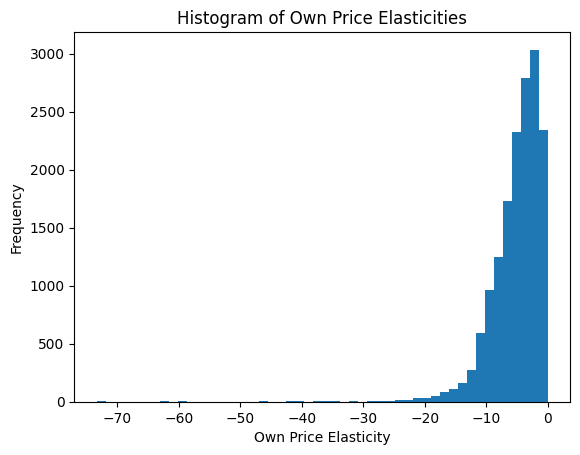

count    15858.000000
mean        -5.105628
std          4.145380
min        -73.328428
25%         -7.025464
50%         -4.245193
75%         -2.225563
max         -0.000000
Name: own_elasticity, dtype: float64


In [ ]:
import matplotlib.pyplot as plt

data['share'] = data['passengers'] / data['mkt_size']
alpha = model.params['price']

# Own-price elasticity for logit:
# ε_jj = α * p_j * (1 - s_j)
data['own_elasticity'] = alpha * data['price'] * (1 - data['share'])

elasticities = data['own_elasticity'].replace([np.inf, -np.inf], np.nan).dropna()

plt.figure()
plt.hist(elasticities, bins=50)
plt.xlabel("Own Price Elasticity")
plt.ylabel("Frequency")
plt.title("Histogram of Own Price Elasticities")
plt.show()

print(elasticities.describe())

### Question 5

Number of AA-DL elasticities: 1146


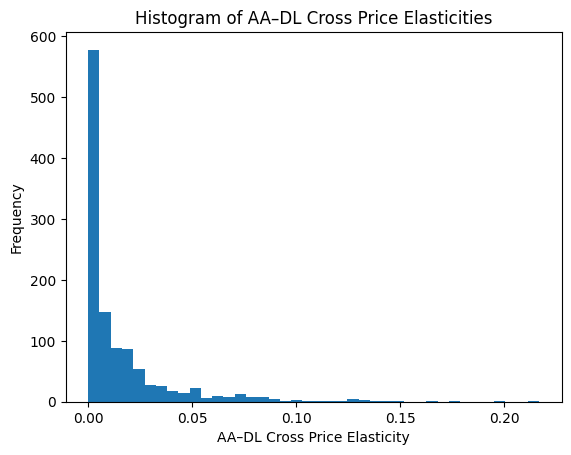

count    1146.000000
mean        0.016230
std         0.027352
min         0.000000
25%         0.001359
50%         0.005272
75%         0.018799
max         0.216757
dtype: float64
                          IV-2SLS Estimation Summary                          
Dep. Variable:                      y   R-squared:                     -0.9951
Estimator:                    IV-2SLS   Adj. R-squared:                -0.9961
No. Observations:               15858   F-statistic:                    1003.0
Date:                Mon, Feb 23 2026   P-value (F-stat)                0.0000
Time:                        21:10:19   Distribution:                  chi2(8)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------

In [ ]:
cross_elasticities = []

AA_ID = 1
DL_ID = 3

for (r, q), g in data.groupby(['route_id', 'quarter']):
    ids = set(g['airline_id'])
    if {AA_ID, DL_ID}.issubset(ids):
        aa = g.loc[g['airline_id'] == AA_ID].iloc[0]
        dl = g.loc[g['airline_id'] == DL_ID].iloc[0]

        # ε_AA,DL = -α * p_DL * s_DL
        eps_AA_DL = -alpha * dl['price'] * dl['share']

        # ε_DL,AA = -α * p_AA * s_AA
        eps_DL_AA = -alpha * aa['price'] * aa['share']

        cross_elasticities.extend([eps_AA_DL, eps_DL_AA])

cross_elasticities = np.array(cross_elasticities)

print("Number of AA-DL elasticities:", len(cross_elasticities))  # should be > 0

plt.figure()
plt.hist(cross_elasticities, bins=40)
plt.xlabel("AA–DL Cross Price Elasticity")
plt.ylabel("Frequency")
plt.title("Histogram of AA–DL Cross Price Elasticities")
plt.show()

print(pd.Series(cross_elasticities).describe())


The AA–DL cross-price elasticities are positive but very small on average (mean ≈ 0.016). This indicates weak substitution between the two airlines in most markets. The distribution is highly skewed, with most elasticities close to zero and a few larger values in concentrated markets. This reflects the IIA property of the multinomial logit model, where substitution depends only on competitors’ market shares.

### Question 6

Under single-product Bertrand pricing (each airline sets its own price for its product in each route–quarter), the firm’s FOC is:

The firm's first-order condition under single-product Bertrand competition is

$$
0 = \frac{\partial \pi_{jct}}{\partial p_{jct}}
= s_{jct} + (p_{jct} - mc_{jct}) \frac{\partial s_{jct}}{\partial p_{jct}}.
$$

Rearranging,

$$
p_{jct} - mc_{jct}
= - \frac{s_{jct}}{\frac{\partial s_{jct}}{\partial p_{jct}}}.
$$

For the multinomial logit model,

$$
\frac{\partial s_{jct}}{\partial p_{jct}}
= \alpha \, s_{jct} (1 - s_{jct}).
$$

Substituting into the first-order condition gives

$$
mc_{jct}
=
p_{jct}
+
\frac{1}{\alpha (1 - s_{jct})}.
$$


In [ ]:
# mc = p + 1 / (alpha * (1 - s))
data['mc'] = data['price'] + 1.0 / (alpha * (1.0 - data['share']))

data['markup'] = data['price'] - data['mc']

print(data[['route_id','quarter','airline_id','price','share','mc','markup']].head(10))
print("\nSummary of implied marginal costs:")
print(data['mc'].describe())

   route_id  quarter  airline_id  price     share          mc     markup
0         1        1           3    244  0.003555  212.002526  31.997474
1         1        2           3    254  0.002148  222.047625  31.952375
2         1        2           5    285  0.000055  253.114506  31.885494
3         1        3           5    160  0.000166  128.110974  31.889026
4         1        3           3    209  0.001573  177.066054  31.933946
5         1        4           3    230  0.002326  198.041950  31.958050
6         2        2           6    134  0.000386  102.103962  31.896038
7         2        3           6    124  0.000094   92.113263  31.886737
8         2        4           6    123  0.000566   91.098214  31.901786
9         3        4           6    227  0.000078  195.113797  31.886203

Summary of implied marginal costs:
count    15858.000000
mean       131.135432
std        132.247127
min        -33.226787
25%         39.114921
50%        104.014801
75%        192.116023
max    

### Question 7

**Merged Firm's FOCs (AA+DL):**

For logit demand, when AA and DL merge, they maximize joint profits. The FOCs internalize cross-effects:

For AA: $$p_{AA} = mc_{AA} - \frac{1}{\alpha}(1 - s_{AA}) - \frac{1}{\alpha} s_{DL}$$

For DL: $$p_{DL} = mc_{DL} - \frac{1}{\alpha}(1 - s_{DL}) - \frac{1}{\alpha} s_{AA}$$

The additional term $-\frac{1}{\\alpha} s_{other}$ captures the fact that raising one product's price increases the other product's market share, and the merged firm internalizes this positive externality.

In [48]:
const = float(model.params["const"])

beta = {1: 0.0}
for aid in sorted(data["airline_id"].unique()):
    if aid == 1:
        continue
    name = f"airline_{aid}"
    beta[int(aid)] = float(model.params[name]) if name in model.params.index else 0.0

# y = log(s) - log(s0) = const + beta_j + alpha*p + xi
data["xi"] = (
    np.log(data["share"]) - np.log(data["share_outside"])
    - const
    - data["airline_id"].map(beta)
    - alpha * data["price"]
)

# mc = p + 1/(alpha*(1-s))
data["mc"] = data["price"] + 1.0 / (alpha * (1.0 - data["share"]))

def firm_id(aid):
    return 13 if aid in (1, 3) else int(aid)

data["firm"] = data["airline_id"].apply(firm_id)

data["mkt_key"] = data["route_id"].astype(str) + "_" + data["quarter"].astype(str)
order = np.argsort(data["mkt_key"].to_numpy())
d = data.iloc[order].reset_index(drop=True)

aid = d["airline_id"].to_numpy(dtype=int)
firm = d["firm"].to_numpy(dtype=int)
xi = d["xi"].to_numpy(dtype=float)
mc = d["mc"].to_numpy(dtype=float)
p0 = d["price"].to_numpy(dtype=float)

# beta as a vector for fast indexing
max_aid = aid.max()
beta_vec = np.zeros(max_aid + 1)
for k,v in beta.items():
    if k <= max_aid:
        beta_vec[k] = v

mkt = d["mkt_key"].to_numpy()
uniq, starts, counts = np.unique(mkt, return_index=True, return_counts=True)
ends = starts + counts

def shares_from_delta(delta_slice):
    # stable softmax with outside good
    m = delta_slice.max()
    expd = np.exp(delta_slice - m)
    sumexp = expd.sum()
    s = expd / (1.0 + sumexp)
    s0 = 1.0 / (1.0 + sumexp)
    return s, s0

def update_prices_market(s, mc_slice, firm_slice):
    # Multi-product Bertrand FOCs
    # 0 = s_j + sum_{k in same firm as j} (p_k - mc_k) * d s_k / d p_j
    J = len(s)
    A = np.zeros((J, J))
    for j in range(J):
        sj = s[j]
        for k in range(J):
            if firm_slice[k] == firm_slice[j]:
                # d s_k / d p_j = alpha * s_k * (1{k=j} - s_j)
                A[j, k] = alpha * s[k] * ((1.0 if k == j else 0.0) - sj)
    # Solve A (p-mc) = -s
    try:
        markup = -np.linalg.solve(A, s)
    except np.linalg.LinAlgError:
        markup = -np.linalg.solve(A + np.eye(J) * 1e-10, s)
    return mc_slice + markup

# EQ
p = p0.copy()
s = np.empty_like(p)

tol = 1e-8
max_iter = 500
damp = 0.5

for it in range(max_iter):
    delta = const + beta_vec[aid] + alpha * p + xi

    # shares market-by-market
    for st, en in zip(starts, ends):
        s_slice, _ = shares_from_delta(delta[st:en])
        s[st:en] = s_slice

    # price update market-by-market
    p_new = np.empty_like(p)
    for st, en in zip(starts, ends):
        p_new[st:en] = update_prices_market(s[st:en], mc[st:en], firm[st:en])

    diff = np.max(np.abs(p_new - p))
    p = (1 - damp) * p + damp * p_new

    if diff < tol:
        print(f"Converged in {it+1} iterations, max delta_p = {diff:.2e}")
        break

merged = (aid == 1) | (aid == 3)

valid = merged & (p0 > 1e-6)
avg_pct_change = np.mean(p[valid] / p0[valid] - 1.0)

print(f"Average % price change for merged firms (AA & DL): {100*avg_pct_change:.2f}%")

Converged in 34 iterations, max delta_p = 7.00e-09
Average % price change for merged firms (AA & DL): 13.50%


The simulation shows an average price increase of 13.50% for AA and DL after the merger.The merged firms raise prices because they no longer compete as aggressively. They internalize that raising one product's price benefits the other product.

From Question 5, we saw that AA and DL are weak substitutes (mean cross-price elasticity ≈ 0.016). However, the merger still leads to a significant price increase.